In [49]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Dataset testing

In [51]:
import torch.utils.data as data
from torchvision import transforms

In [ ]:
class OccMapDataset(data.Dataset):
    def __init__(self, filename='./description_ang0.csv', transform=None, input_dir='./inp_data/', target_dir='./gt_data/', mode='train'):
        # Your code 
        df = pd.read_csv(filename)
        df = df[df['free_perc'] <= 80]
        
        df['FloorID'] = df['FloorName'].apply(lambda x: int(x[-3:]))
        if mode == 'train':
            df = df[df['FloorID'] <= 220]
        else:
            df = df[df['FloorID'] > 220]
        
        self.filepaths = my_df['Filename'].values
        
        self.transform = transform
        self.input_dir = input_dir
        self.target_dir = target_dir

    def __len__(self):
        # Your code 
        return len(self.filepaths)
    
    def __getitem__(self, index):
        # Your code
        filename = self.filepaths[index]
        inp_img = np.load(f'{self.input_dir}/{my_filenames[0]}.npy')
        tgt_img = np.load(f'{self.output_dir}/{my_filenames[0]}.npy')
        
        data_dict = {'input image': inp_img, 'target image': tgt_img}
        
        if self.transform is not None:
            data_dict['input image'] = self.transform(data_dict['input image'])
            data_dict['target image'] = self.transform(data_dict['target image'])
        
        return data_dict

In [53]:
my_df = pd.read_csv('description_ang0.csv')
my_df.head()

,Unnamed: 0,Filename,FloorName,pos_x,pos_y,pos_z,ang_x,ang_y,ang_z,free_perc
0,0,FP201_0,FloorPlan201,-4.0,0.902657,1.5,0,0,0,71.540833
1,1,FP201_1,FloorPlan201,-4.0,0.902657,1.5,0,45,0,72.044373
2,2,FP201_2,FloorPlan201,-4.0,0.902657,1.5,0,90,0,68.254089
3,3,FP201_3,FloorPlan201,-4.0,0.902657,1.5,0,135,0,76.741028
4,4,FP201_4,FloorPlan201,-4.0,0.902657,1.5,0,180,0,84.309387


In [62]:
# my_df.shape
# pd.unique(my_df[ my_df['FloorName'].values in [f'FloorPlan{k}' for k in range(201,220+1)]])
# my_df['FloorID'] = my_df['FloorName'].apply(lambda x: int(x[-3:]))
my_df.shape, my_df[my_df['FloorID'] <= 220].shape

((15096, 11), (10864, 11))

<AxesSubplot:>

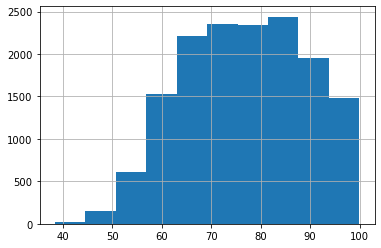

In [50]:
my_df['free_perc'].hist()

In [51]:
my_df = my_df[my_df['free_perc'] <= 80]
my_filenames = my_df['Filename'].values
print(len(my_filenames))

8641


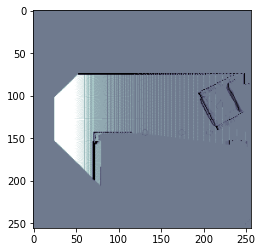

In [52]:
plt.imshow(np.load(f'inp_data/{my_filenames[0]}.npy'), cmap='bone_r')

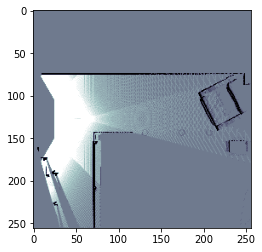

In [53]:
plt.imshow(np.load(f'gt_data/{my_filenames[0]}.npy'), cmap='bone_r')

In [1]:
import torch
from dataloader import OccMapDataset
from torchvision import transforms

In [2]:
transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.ConvertImageDtype(torch.float)
            ])
# load the data
full_set = OccMapDataset(filename='./description_ang0.csv', transform=transform)

In [3]:
full_loader = torch.utils.data.DataLoader(full_set, batch_size=12, shuffle=True, num_workers=2)

In [4]:
for data in full_loader:
    break

In [5]:
data['input image'].shape, data['target image'].shape

(torch.Size([12, 1, 256, 256]), torch.Size([12, 1, 256, 256]))

In [6]:
full_loader.batch_size

12

## Solver

In [54]:
from torch.utils.tensorboard import SummaryWriter

In [55]:
import torch.nn as nn

In [ ]:
nn.MSELoss()

# Test utility testing

In [1]:
from train import *

In [5]:
# Defining transform
transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.ConvertImageDtype(torch.float)
        ])
# load the data
trainval_set = OccMapDataset(filename='./description_ang0.csv', transform=transform, mode='train')
test_set = OccMapDataset(filename='./description_ang0.csv', transform=transform, mode='test')

trainval_size = len(trainval_set)

train_size = int((100 - 10)/100. * trainval_size)
valid_size = trainval_size - train_size
test_size = len(test_set)

print(f'Data sizes:\nTrain: {train_size}\nValid: {valid_size}\nTest: {test_size}')

train_set, valid_set = torch.utils.data.random_split(trainval_set, [train_size, valid_size])

# data loader
train_loader = torch.utils.data.DataLoader(train_set, batch_size=16, shuffle=True, num_workers=2)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=2*16, shuffle=False, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=2*16, shuffle=False, num_workers=2)
# model
net = UNet(n_channels=1, n_classes=1, bilinear=True)

# train the model
# model_path = f"./saved_models/{'sgd'}_LR_{0.01}_epoch_{50}.pth"
model_path = f"./saved_models/sgd_LR_0.01_epoch_100_bce_scale_1.0_PROB_ODDSCLAE10.pth"

solver = Solver(net, optimizer='sgd', lr=0.01, max_epoch=50, 
                verbose=True, save_best=True, early_stop=5, 
                outfile=model_path, save_full=True)
print(f'Loading pre-trained model from {model_path}')
# solver.net.load_state_dict(torch.load(model_path))
solver.net = torch.load(model_path)

test_loss = solver.test(loader=test_loader)
print(f'Test loss: {test_loss}')


Data sizes:
Train: 5641
Valid: 627
Test: 2373
Model will use:
	Loss function: mse
	Optimizer: sgd
	LR: 0.01
	Max epochs: 50
	Early stop: 5
	Scale: 1.0
Loading pre-trained model from ./saved_models/sgd_LR_0.01_epoch_100_bce_scale_1.0_PROB_ODDSCLAE10.pth
Test loss: 0.0016672248998656869


In [6]:
for data in test_loader:
    images = data['input image']
    labels = data['target image']

    # placing data on device
    images = images.to(solver.device)
    labels = labels.to(solver.device)

    # We don't need gradients here
    with torch.no_grad():
        # forward propagation 
        preds = solver.net(images)
    break

In [7]:
preds.shape

torch.Size([32, 1, 256, 256])

In [8]:
from torchvision.utils import make_grid, save_image

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F

In [10]:
def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

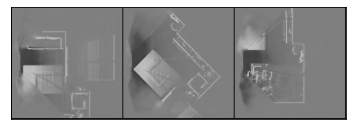

In [11]:
show(make_grid(preds[:3].cpu()))

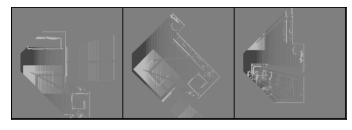

In [12]:
show(make_grid(images[:3].cpu()))

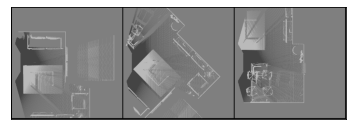

In [13]:
show(make_grid(labels[:3].cpu()))

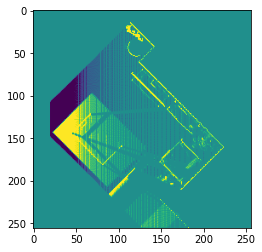

In [14]:
plt.imshow(images.cpu().data[1,0])

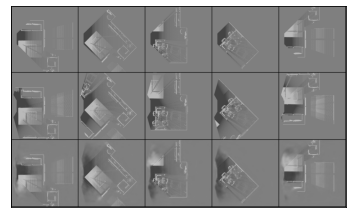

In [15]:
show(make_grid(torch.cat([images[:5], labels[:5], preds[:5]], axis=0).cpu(), nrow=5))

In [35]:
save_image(make_grid(torch.cat([images[:5], labels[:5], preds[:5]], axis=0).cpu(), nrow=5), 'example.png' )

# Test test utility

In [16]:
import torch
import torch.nn as nn
from torchvision import transforms

from tqdm import tqdm
from dataloader import OccMapDataset
from models import UNet

from torchvision.utils import make_grid, save_image

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [17]:
from train import Solver

In [18]:
# Defining transform
transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.ConvertImageDtype(torch.float)
        ])
# load the data
test_set = OccMapDataset(filename='./description_ang0.csv', transform=transform, mode='test')

test_size = len(test_set)

print(f'Test data size: {test_size}')

# data loader
test_loader = torch.utils.data.DataLoader(test_set, batch_size=32, shuffle=True, num_workers=2)

# model
net = UNet(n_channels=1, n_classes=1, bilinear=True)

# load the model
# model_path = './saved_models/sgd_LR_0.01_epoch_100_MSEProb.pth' #args.model_path
model_path = "./saved_models/sgd_LR_0.01_epoch_100_bce_scale_1.0_PROB_ODDSCLAE10.pth"

solver = Solver(net, optimizer='sgd', loss_fn='mse', lr=0.01, max_epoch=1, 
                verbose=True, save_best=True, early_stop=5, 
                outfile=model_path, save_full=True, scale=1.0, device=torch.device('cpu'))


solver.net = torch.load(model_path)
solver.net = solver.net.to(solver.device)

Test data size: 2373
Model will use:
	Loss function: mse
	Optimizer: sgd
	LR: 0.01
	Max epochs: 1
	Early stop: 5
	Scale: 1.0


In [19]:
input_list = []
gt_list = []
pred_list = []
## Plottig results
for data in tqdm(test_loader):
    images = data['input image']
    labels = data['target image']

    # placing data on device
    images = images.to(solver.device)
    labels = labels.to(solver.device)

    # We don't need gradients here
    with torch.no_grad():
        # forward propagation 
        preds = solver.net(images)
        
    input_list.append(images.cpu().data.numpy())
    gt_list.append(labels.cpu().data.numpy())
    pred_list.append(preds.cpu().data.numpy())
    
    if len(input_list) == 2:
        break


  1%|█▎                                                                                                   | 1/75 [00:15<19:15, 15.62s/it]


In [20]:
o_inp = np.concatenate(input_list)
o_gt = np.concatenate(gt_list)
o_pred = np.concatenate(pred_list)

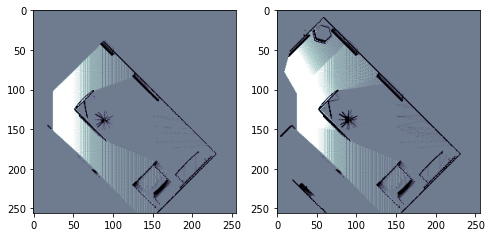

In [21]:
figs, axes = plt.subplots(1,2, figsize=(8,8))
axes[0].imshow(o_inp[0,0], cmap='bone_r')
axes[1].imshow(o_gt[0,0], cmap='bone_r')

In [22]:
o_inp[0,0].max(), o_inp[0,0].min(), o_inp[0,0,-1,-1]

(0.7310586, 0.26894143, 0.5)

In [23]:
o_gt[0,0].max(), o_gt[0,0].min(), o_gt[0,0,-1,-1]

(0.7310586, 0.26894143, 0.5)

In [24]:
o_pred[0,0].max(), o_pred[0,0].min(), o_pred[0,0,-1,-1]

(0.7795706, 0.1877757, 0.51150584)

In [12]:
o_inp.shape, o_gt.shape, o_pred.shape

((64, 1, 256, 256), (64, 1, 256, 256), (64, 1, 256, 256))

In [25]:
# inpainted = (o_inp == 0) & (o_pred != 0)
# sensed_cells = (o_inp != 0)

inpainted = (o_inp == 0.5) & ((o_pred > 0.505) | (o_pred < 0.495))
sensed_cells = (o_inp != 0.5)

In [30]:
inpainted.shape, sensed_cells.shape
# frac_inp = inpainted.reshape(inpainted.shape[0], -1).sum(axis=1)/sensed_cells.reshape(sensed_cells.shape[0],-1).sum(axis=1)
# frac_inp = inpainted.reshape(inpainted.shape[0], -1).sum(axis=1)/sensed_cells.reshape(sensed_cells.shape[0],-1).sum(axis=1)
# frac_inp = inpainted.reshape(inpainted.shape[0], -1).sum(axis=1)/(o_inp.shape[-1]*o_inp.shape[-2])
frac_inp =  inpainted.reshape(inpainted.shape[0], -1).sum(axis=1)/(o_inp.shape[-1]*o_inp.shape[-2])

<AxesSubplot:ylabel='Count'>

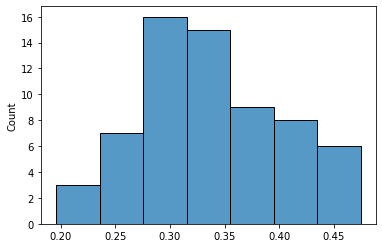

In [31]:
sns.histplot(frac_inp)

In [16]:
o_gt.min(), o_gt.max()

(0.26894143, 0.7310586)

In [17]:
eg_loss = nn.MSELoss()
eg_loss(labels, preds)

tensor(0.0057)

In [25]:
eg_loss = nn.KLDivLoss(reduction='batchmean')
# eg_loss = nn.KLDivLoss(reduction='mean')
# eg_loss = nn.KLDivLoss()
eg_loss(labels, preds)

tensor(-39214.8828)

In [16]:
def convert_to_occ(arr, low_prob_thresh=0.495, high_prob_thresh=0.505):
    occ_map = np.zeros(arr.shape, dtype=np.int) # default unknown
    occ_map[arr < low_prob_thresh] = -1 # free
    occ_map[arr > high_prob_thresh] = 1 # occupied
    
    return occ_map

In [57]:
o_pred_filt = o_pred.copy()
o_pred_filt[ (o_pred_filt < 0.05) & (o_pred_filt > -0.05)] = 0.0

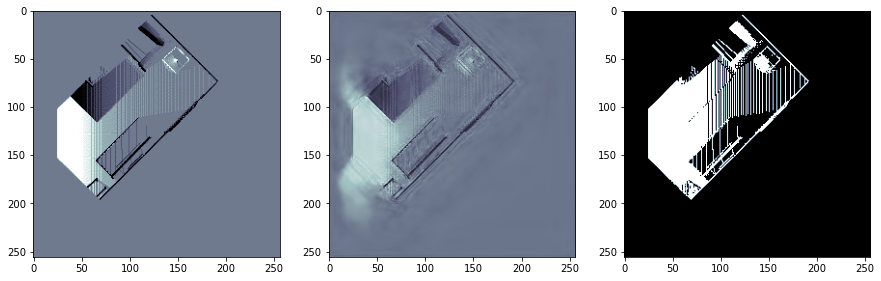

In [56]:
# plt.imshow()
# plt.imshow(np.hstack([o_inp[0,0], o_pred[0,0], inpainted[0,0]]))
figs, axes = plt.subplots(1,3, figsize=(15,8))
axes[0].imshow(o_inp[0,0], cmap='bone_r')
axes[1].imshow(o_pred[0,0], cmap='bone_r')
axes[2].imshow(inpainted[0,0], cmap='bone_r')

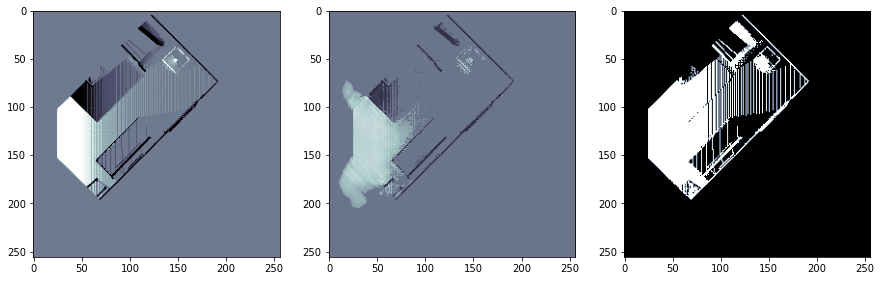

In [58]:
# plt.imshow()
# plt.imshow(np.hstack([o_inp[0,0], o_pred[0,0], inpainted[0,0]]))
figs, axes = plt.subplots(1,3, figsize=(15,8))
axes[0].imshow(o_inp[0,0], cmap='bone_r')
axes[1].imshow(o_pred_filt[0,0], cmap='bone_r')
axes[2].imshow(inpainted[0,0], cmap='bone_r')

In [45]:
# occ_map_pred = convert_to_occ((o_pred +0.2)/0.2)
# occ_map_gt = convert_to_occ((o_gt +0.2)/0.2)
occ_map_pred = convert_to_occ( np.exp(o_pred)/(1+np.exp(o_pred)) )
occ_map_gt = convert_to_occ( np.exp(o_gt)/(1+np.exp(o_gt)) )

In [46]:
match  = (occ_map_pred == occ_map_gt)

In [47]:
match.shape, inpainted.shape, #match[inpainted].shape

((96, 1, 256, 256), (96, 1, 256, 256))

In [48]:
acc = match.reshape(match.shape[0],-1).sum(axis=1)/inpainted.reshape(inpainted.shape[0], -1).sum(axis=1)

In [49]:
inpainted_flat = inpainted.reshape(inpainted.shape[0], -1)
match_flat = match.reshape(match.shape[0], -1)

acc = (match_flat * inpainted_flat).sum(axis=1)/inpainted_flat.sum(axis=1)

In [50]:
acc.mean()

0.9063324853213839

Text(0.5, 1.0, 'Accuracy histogram')

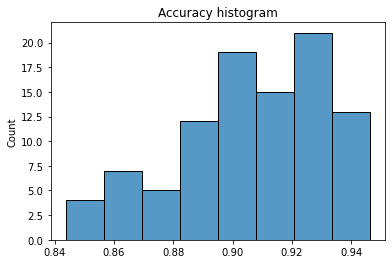

In [51]:
sns.histplot(acc).set_title('Accuracy histogram')

In [59]:
np.exp(0.1)/(1+np.exp(0.1))

0.52497918747894

In [60]:
np.exp(0.01)/(1+np.exp(0.01))

0.5024999791668749

In [63]:
np.exp(-0.1)/(1+np.exp(-0.01))

0.4546807837124786

In [61]:
np.exp(-0.01)/(1+np.exp(-0.01))

0.497500020833125

In [53]:
np.exp(0.0)/(1+np.exp(0.0))

0.5

In [54]:
np.exp(1.0)/(1+np.exp(1.0))

0.7310585786300049

In [64]:
np.exp(10.0)/(1+np.exp(10.0))

0.9999546021312976

In [65]:
np.exp(-10.0)/(1+np.exp(-10.0))

4.5397868702434395e-05

# Testing issue with KL Loss

In [1]:
import torch
import torch.nn as nn
from torchvision import transforms

from tqdm import tqdm
from dataloader import OccMapDataset
from models import UNet

from torchvision.utils import make_grid, save_image

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from train import Solver

In [3]:
# Defining transform
transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.ConvertImageDtype(torch.float)
        ])
# load the data
test_set = OccMapDataset(filename='./description_ang0.csv', transform=transform, mode='test')

test_size = len(test_set)

print(f'Test data size: {test_size}')

# data loader
test_loader = torch.utils.data.DataLoader(test_set, batch_size=32, shuffle=True, num_workers=2)

# model
net = UNet(n_channels=1, n_classes=1, bilinear=True)

# load the model
model_path = './saved_models/sgd_LR_0.01_epoch_100_MSEProb.pth' #args.model_path

solver = Solver(net, optimizer='sgd', loss_fn='kl_raw', lr=0.01, max_epoch=1, 
                verbose=True, save_best=True, early_stop=5, 
                outfile=model_path, save_full=True, scale=1.0, device=torch.device('cpu'))


solver.net = torch.load(model_path)
solver.net = solver.net.to(solver.device)

Test data size: 2373
Using KL loss diretcly
Testing: loss for same distributions is 0.0
Model will use:
	Loss function: kl_raw
	Optimizer: sgd
	LR: 0.01
	Max epochs: 1
	Early stop: 5
	Scale: 1.0


/home/vishnuds/anaconda3/envs/ptorch/lib/python3.8/site-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))
/home/vishnuds/anaconda3/envs/ptorch/lib/python3.8/site-packages/torch/nn/functional.py:2352: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."


In [4]:
input_list = []
gt_list = []
pred_list = []
## Plottig results
for data in tqdm(test_loader):
    images = data['input image']
    labels = data['target image']

    # placing data on device
    images = images.to(solver.device)
    labels = labels.to(solver.device)

    # We don't need gradients here
    with torch.no_grad():
        # forward propagation 
        preds = solver.net(images)
        
    input_list.append(images.cpu().data.numpy())
    gt_list.append(labels.cpu().data.numpy())
    pred_list.append(preds.cpu().data.numpy())
    
    if len(input_list) == 2:
        break


  1%|█▎                                                                                                   | 1/75 [00:15<19:39, 15.93s/it]


In [5]:
solver.criterion(images, labels)

tensor(0.0073)

In [6]:
solver.criterion(images, images)

tensor(0.)

In [7]:
solver.criterion(labels, images)

tensor(-0.0026)

In [8]:
solver.criterion(preds, images)

tensor(0.0108)

In [9]:
solver.criterion(preds, labels)

tensor(0.0182)

In [10]:
solver.criterion(input=preds, target=labels), solver.criterion(target=labels, input=preds)

(tensor(0.0182), tensor(0.0182))

In [11]:
solver.criterion(input=0*preds, target=labels)

tensor(0.8480)

In [9]:
solver.criterion(input=1.0 * preds, target=1.0*labels), solver.criterion(target=1.0 * labels, input= 1.0 * preds)

(tensor(0.0182), tensor(0.0182))

In [10]:
solver.criterion(input=1.0 * images, target=1.0*labels), solver.criterion(target=1.0 * labels, input= 1.0 * images)

(tensor(0.0073), tensor(0.0073))

In [11]:
solver.criterion(input=images, target=labels), solver.criterion(target=labels, input=images)

(tensor(0.0073), tensor(0.0073))

In [12]:
m = nn.Softmax2d()

In [14]:
m(preds).shape

torch.Size([32, 1, 256, 256])

In [16]:
m(preds).min()

tensor(1.)

In [18]:
nn.functional.softmax(preds)[0,0]

/tmp/ipykernel_17011/3217068252.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  nn.functional.softmax(preds)[0,0]


tensor([[1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        ...,
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.]])

In [ ]:
preds.flatten()

In [6]:
loss = nn.KLDivLoss()

In [7]:
loss(images, labels)

tensor(-0.5957)

In [8]:
loss(images, images)

tensor(-0.5984)

In [9]:
loss(images.reshape(32,-1), images.reshape(32,-1))

tensor(-0.5984)

In [10]:
images.shape

torch.Size([32, 1, 256, 256])

In [11]:
loss = nn.KLDivLoss(log_target=True)

In [12]:
loss(input=preds, target=preds), loss(input=preds, target=labels), loss(input=preds, target=torch.ones(labels.shape))

(tensor(0.), tensor(0.0182), tensor(1.3614))

In [13]:
loss = nn.KLDivLoss(log_target=False)

In [14]:
loss(input=preds, target=preds),  loss(input=preds, target=labels), loss(input=preds, target=torch.ones(labels.shape))

(tensor(-0.5960), tensor(-0.5909), tensor(-0.4992))

In [15]:
loss = nn.KLDivLoss(log_target=False, reduce='batchmean')

In [16]:
loss(input=preds, target=preds), loss(input=preds, target=labels), loss(input=preds, target=torch.ones(labels.shape))

(tensor(-0.5960), tensor(-0.5909), tensor(-0.4992))

In [17]:
loss = nn.KLDivLoss(log_target=True)

In [18]:
loss(input=preds, target=preds), loss(input=preds, target=labels), loss(input=preds, target=torch.ones(labels.shape))

(tensor(0.), tensor(0.0182), tensor(1.3614))

In [19]:
loss(input=images, target=labels)

tensor(0.0073)

In [20]:
loss = nn.KLDivLoss(log_target=True, reduce='batchmean')

In [21]:
loss(input=preds, target=preds), loss(input=preds, target=labels), loss(input=preds, target=torch.ones(labels.shape))

(tensor(0.), tensor(0.0182), tensor(1.3614))

In [22]:
loss(input=images, target=labels)

tensor(0.0073)

# Testing datasets 

(testing again as the random flipping didn't flip both images)

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt

In [28]:
import torch.utils.data as data
from torchvision import transforms

import torch

In [5]:
import pandas as pd
import numpy as np

In [2]:
class OccMapDataset(data.Dataset):
    def __init__(self, filename='./description_ang0.csv', transform=None, input_dir='./inp_data/', target_dir='./gt_data/', mode='train', odds_to_prob=True, scale=10.):
        # Your code 
        df = pd.read_csv(filename)
        df = df[df['free_perc'] <= 80]
        
        df['FloorID'] = df['FloorName'].apply(lambda x: int(x[-3:]))
        if mode == 'train':
            df = df[df['FloorID'] <= 220]
        else:
            df = df[df['FloorID'] > 220]
            
        self.filepaths = df['Filename'].values
        
        self.transform = transform
        self.input_dir = input_dir
        self.target_dir = target_dir

        self.odds_to_prob = odds_to_prob
        self.scale = scale


    def __len__(self):
        # Your code 
        return len(self.filepaths)
    
    def __getitem__(self, index):
        # Your code
        filename = self.filepaths[index]
        inp_img = np.load(f'{self.input_dir}/{self.filepaths[index]}.npy')
        tgt_img = np.load(f'{self.target_dir}/{self.filepaths[index]}.npy')
        
        data_dict = {'input image': inp_img[:, :], 'target image': tgt_img[ :, :]}
        data_dict['input image'] *= self.scale
        data_dict['target image'] *= self.scale
        
        if self.odds_to_prob:
            o2p_func = lambda x: np.exp(x)/(1. + np.exp(x))
            data_dict['input image'] = o2p_func(data_dict['input image'])
            data_dict['target image'] = o2p_func(data_dict['target image'])

        if self.transform is not None:
            data_dict['input image'] = self.transform(data_dict['input image'])
            data_dict['target image'] = self.transform(data_dict['target image'])
         
        return data_dict

In [6]:
# Defining transform
transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.RandomVerticalFlip(p=0.5),
            transforms.ConvertImageDtype(torch.float)
        ])
# load the data
test_set = OccMapDataset(filename='./description_ang0.csv', transform=transform, mode='test')

In [7]:
test_loader = torch.utils.data.DataLoader(test_set, batch_size=16, shuffle=False, num_workers=2)

In [10]:
## Plttig results
for data in test_loader:
    images = data['input image']
    labels = data['target image']
    break

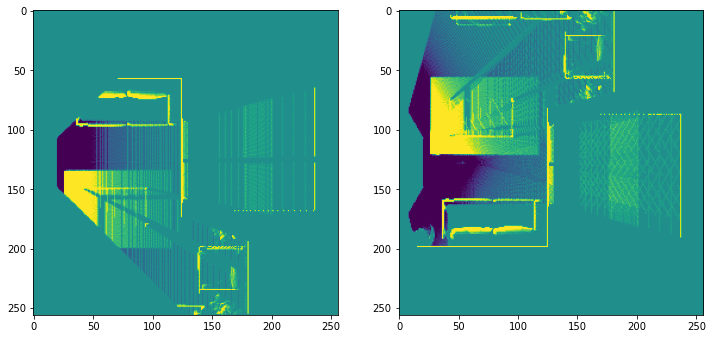

In [17]:
fix, axs = plt.subplots(1,2, figsize=(12,6))
i = 1

axs[0].imshow(images.cpu().data.numpy()[0,0])
axs[1].imshow(labels.cpu().data.numpy()[0,0])

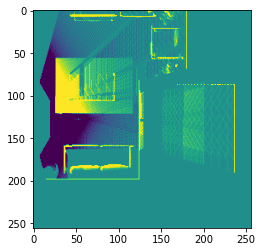

In [18]:
import torchvision.transforms.functional as TF

In [29]:
class OccMapDataset(data.Dataset):
    def __init__(self, filename='./description_ang0.csv', transform=None, input_dir='./inp_data/', target_dir='./gt_data/', mode='train', odds_to_prob=True, scale=10.):
        # Your code 
        df = pd.read_csv(filename)
        df = df[df['free_perc'] <= 80]
        
        df['FloorID'] = df['FloorName'].apply(lambda x: int(x[-3:]))
        if mode == 'train':
            df = df[df['FloorID'] <= 220]
        else:
            df = df[df['FloorID'] > 220]
            
        self.filepaths = df['Filename'].values
        
        self.transform = transform
        self.input_dir = input_dir
        self.target_dir = target_dir

        self.odds_to_prob = odds_to_prob
        self.scale = scale


    def __len__(self):
        # Your code 
        return len(self.filepaths)
    
    def __getitem__(self, index):
        # Your code
        filename = self.filepaths[index]
        inp_img = np.load(f'{self.input_dir}/{self.filepaths[index]}.npy')
        tgt_img = np.load(f'{self.target_dir}/{self.filepaths[index]}.npy')
        
        data_dict = {'input image': inp_img[:, :], 'target image': tgt_img[ :, :]}
        data_dict['input image'] *= self.scale
        data_dict['target image'] *= self.scale
        
        if self.odds_to_prob:
            o2p_func = lambda x: np.exp(x)/(1. + np.exp(x))
            data_dict['input image'] = o2p_func(data_dict['input image'])
            data_dict['target image'] = o2p_func(data_dict['target image'])

        if self.transform is not None:
            data_dict['input image'] = self.transform(data_dict['input image'])
            data_dict['target image'] = self.transform(data_dict['target image'])
            
        if np.random.random() > 0.5:
            data_dict['input image'] = TF.vflip(data_dict['input image'])
            data_dict['target image'] = TF.vflip(data_dict['target image'])
         
        return data_dict

In [30]:
# Defining transform
transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.ConvertImageDtype(torch.float)
        ])
# load the data
test_set = OccMapDataset(filename='./description_ang0.csv', transform=transform, mode='test')

In [31]:
test_loader = torch.utils.data.DataLoader(test_set, batch_size=16, shuffle=False, num_workers=2)

In [32]:
## Plttig results
for data in test_loader:
    images = data['input image']
    labels = data['target image']
    break

IndexError: index 16 is out of bounds for axis 0 with size 16

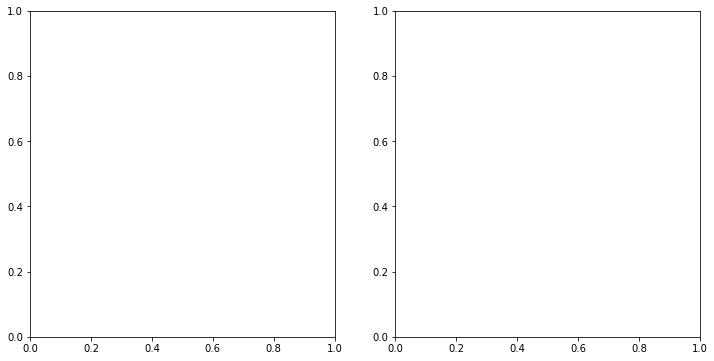

In [57]:
fix, axs = plt.subplots(1,2, figsize=(12,6))
i = 16

axs[0].imshow(images.cpu().data.numpy()[i,0])
axs[1].imshow(labels.cpu().data.numpy()[i,0])